# Training a Machine Learning Classifier for HP-PPI Prediction Task

Classifier: Random Forest

In [11]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from hyperopt import hp, tpe, STATUS_OK, space_eval
from hyperopt.fmin import fmin

from IPython.display import display, Markdown

In [2]:
# Set up directories
parent_dir = os.path.dirname(os.getcwd())

dir_in = os.path.join(parent_dir, 'data', 'features')
dir_out = os.path.join(parent_dir, 'data', 'results')

In [3]:
# Function for combining datasets
def get_dataset(pathogens):
    '''Combine features and labels of different pathogen datasets'''
    
    X = []
    y = []
    
    # Iterate through datasets
    for pathogen in pathogens:
        f_in = os.path.join(dir_in, '%s_features.npz' % pathogen)
        data = np.load(f_in)
        X.append(data['X'])
        y.append(data['y'])
    
    # Combine features (X) and labels (y)
    X = np.vstack(X)
    y = np.concatenate(y)
    
    return X, y

## Hyperparameter Tuning

Bayesian optimization with `hyperopt`

In [4]:
# Load all datasets
pathogens = ['Bacan', 'Yerpe', 'Fratu']
X, y = get_dataset(pathogens)

In [8]:
# Define scoring and objective functions

## Scoring function
def get_score(params):
    clf = RandomForestClassifier(**params,
                                 class_weight='balanced',
                                 random_state=7)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    
    score = cross_val_score(clf, X, y, cv=cv, scoring='f1', n_jobs=4)
    return score.mean()

## Objective function
def f(params):
    score = get_score(params)
    return {'loss': -score, 'status': STATUS_OK}

In [ ]:
# Define hyperparameter search space
param_space = {
    'n_estimators': hp.choice('n_estimators', range(10, 201, 10)),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', list(range(10, 101)) + [None]),
    'max_features': hp.choice('max_features', range(10, 101)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 151)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 101))
}

# Begin optimization
best = fmin(f, param_space, algo=tpe.suggest, max_evals=20)

# Obtain parameters of best model
best_params = space_eval(param_space, best)

In [5]:
# Set up classifier
clf = RandomForestClassifier(**params, class_weight='balanced', n_jobs=4)
_ = clf.fit(X, y)

# Dump model as pickle
_ = joblib.dump(clf, 'RF_best.pkl')

In [9]:
# Examine metrics
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

print(classification_report(y, y_pred, digits=4))
    
# Plot metrics
_ = plot_confusion_matrix(y, y_pred)
_ = plot_roc(y, y_proba)
_ = plt.show()

[10, 20, 30, 40]

## Training random forest classifier

                               Test 1                                
                          Test Pathogen: Bacan
                          
              precision    recall  f1-score   support

           0     0.8600    0.9316    0.8944     10777
           1     0.6050    0.4085    0.4877      2764

    accuracy                         0.8248     13541
   macro avg     0.7325    0.6700    0.6910     13541
weighted avg     0.8079    0.8248    0.8113     13541



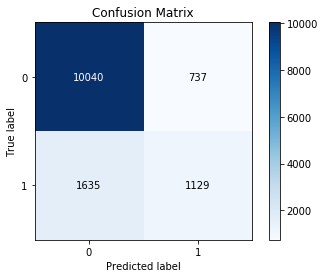

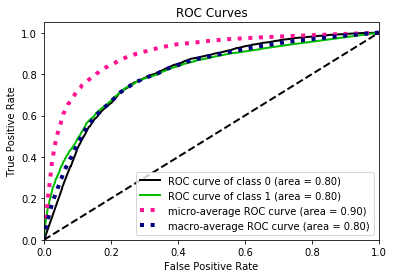

<hr></hr>

                               Test 2                                
                          Test Pathogen: Yerpe
                          
              precision    recall  f1-score   support

           0     0.8442    0.9570    0.8970     13137
           1     0.6919    0.3535    0.4679      3590

    accuracy                         0.8275     16727
   macro avg     0.7680    0.6552    0.6825     16727
weighted avg     0.8115    0.8275    0.8049     16727



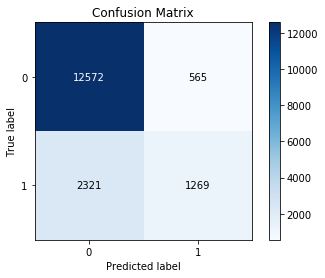

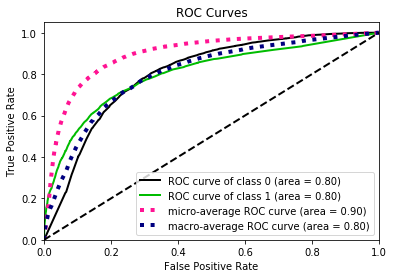

<hr></hr>

                               Test 3                                
                          Test Pathogen: Fratu
                          
              precision    recall  f1-score   support

           0     0.8725    0.9620    0.9151      3500
           1     0.8394    0.5855    0.6898      1187

    accuracy                         0.8667      4687
   macro avg     0.8559    0.7738    0.8024      4687
weighted avg     0.8641    0.8667    0.8580      4687



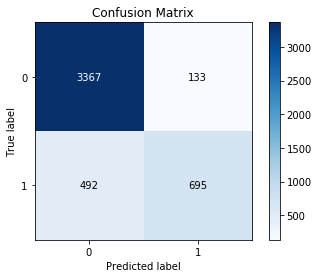

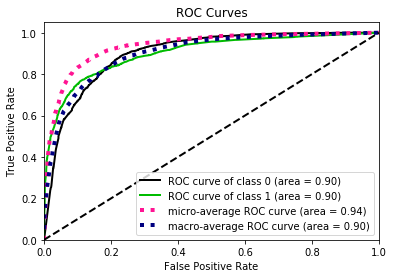

<hr></hr>

In [6]:
# Train and test classifier on different datasets
## Partition datasets by pathogen species
i = 0 # track number of tests

for p_test in pathogens:
    p_train = [p for p in pathogens if p != p_test]
    X, y = get_dataset(p_train)
    
    # Train classifier
    _ = clf.fit(X, y)
    
    # Evaluate performance on test set
    X, y = get_dataset([p_test])
    y_pred = clf.predict(X)
    y_proba = clf.predict_proba(X)
    
    del X, y
    i += 1
    
    print('Test %i'.center(70) % i)
    print('Test Pathogen: %s\n'.center(70) % p_test)
    print(classification_report(y, y_pred, digits=4))
    
    # Plot metrics
    _ = plot_confusion_matrix(y, y_pred)
    _ = plot_roc(y, y_proba)
    _ = plt.show()
    
    display(Markdown('<hr></hr>'))

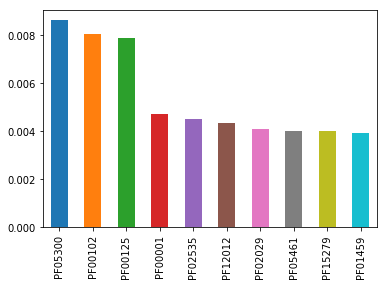

In [7]:
# Examine feature importances
## Get feature names (Pfam accessions)
pfam = joblib.load('pfam.pkl')[1]

feat_importances = pd.Series(clf.feature_importances_,
                             index=pfam)
_ = feat_importances.nlargest(10).plot(kind='bar')